In [2]:
# HIDDEN
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from pathlib import Path
from ds100_utils import fetch_and_cache
from datetime import datetime
from IPython.display import display

import yaml

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Sam's special methods to display large DataFrames
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [4]:
def plot_vec(x_dir, y_dir):
    plt.quiver(0, 0, x_dir, y_dir, scale_units='xy', angles='xy',
               scale=0.1, color='red')

## Voting Patterns in Congress

In [5]:
# From Lecture 4
base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'
legislators_path = 'legislators-current.yaml'
f = fetch_and_cache(base_url + legislators_path, legislators_path)
legislators_data = yaml.safe_load(open(f))

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

legs = pd.DataFrame(
    columns=['leg_id', 'first', 'last', 'gender', 'state', 'chamber', 'party', 'birthday'],
    data=[[x['id']['bioguide'], 
           x['name']['first'],
           x['name']['last'],
           x['bio']['gender'],
           x['terms'][-1]['state'],
           x['terms'][-1]['type'],
           x['terms'][-1]['party'],
           to_date(x['bio']['birthday'])] for x in legislators_data])

legs

Using cached version that was downloaded (UTC): Mon Jul  8 22:27:32 2019


,leg_id,first,last,gender,state,chamber,party,birthday
0,B000944,Sherrod,Brown,M,OH,sen,Democrat,1952-11-09
1,C000127,Maria,Cantwell,F,WA,sen,Democrat,1958-10-13
2,C000141,Benjamin,Cardin,M,MD,sen,Democrat,1943-10-05
...,...,...,...,...,...,...,...,...
536,M001197,Martha,McSally,F,AZ,sen,Republican,1966-03-22
537,G000592,Jared,Golden,M,ME,rep,Democrat,1982-07-25
538,K000395,Fred,Keller,M,PA,rep,Republican,1965-10-23


In [6]:
# February 2019 House of Representatives roll call votes
# Downloaded using https://github.com/eyeseast/propublica-congress
votes = pd.read_csv('votes.csv')
votes

,chamber,session,roll call,member,vote
0,House,1,87,A000374,No
1,House,1,87,A000370,Yes
2,House,1,87,A000055,No
...,...,...,...,...,...
9529,House,1,66,Y000033,Yes
9530,House,1,66,Z000017,Yes
9531,House,1,66,P000197,Speaker


In [7]:
votes.merge(legs, left_on='member', right_on='leg_id').sample(5)

,chamber_x,session,roll call,member,...,state,chamber_y,party,birthday
4132,House,1,69,H001073,...,TX,rep,Republican,1977-08-19
4825,House,1,80,L000578,...,CA,rep,Republican,1960-07-02
5425,House,1,74,L000562,...,MA,rep,Democrat,1955-03-31
8837,House,1,72,V000132,...,TX,rep,Democrat,1963-02-13
6585,House,1,80,P000197,...,CA,rep,Democrat,1940-03-26


In [8]:
yes_no = votes[votes['vote'] == 'Yes']
vote_pivot = yes_no.pivot_table(index='member', 
                                columns='roll call', 
                                values='vote', 
                                aggfunc=len, 
                                fill_value=0)
print(vote_pivot.shape)
vote_pivot

(436, 22)


roll call,66,67,68,69,...,84,85,86,87
member,,,,,,,,,
A000055,1,1,0,0,...,1,0,0,0
A000367,0,0,0,0,...,1,0,0,0
A000369,1,1,0,0,...,1,0,0,1
...,...,...,...,...,...,...,...,...,...
Y000062,1,1,1,1,...,1,1,1,1
Y000065,1,0,0,0,...,1,0,0,0
Z000017,1,1,0,0,...,1,0,0,0


In [10]:
np.var(vote_pivot, axis=0).sort_values()

roll call
82    0.03
84    0.04
70    0.04
      ... 
78    0.25
69    0.25
80    0.25
Length: 22, dtype: float64

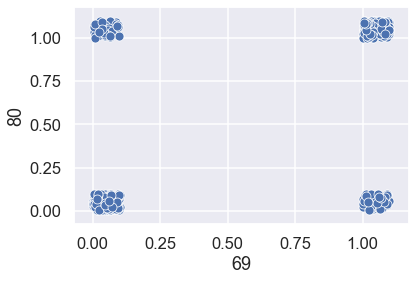

In [14]:
sns.scatterplot(69, 80, data=vote_pivot + np.random.random(vote_pivot.shape) * 0.1);

This doesn't say much...

## Linear Algebra

### Matrices

In [15]:
matrix = np.arange(1, 13).reshape(3, 4)
matrix

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [21]:
0.5*matrix[0] + 0*matrix[1] + 0.5*matrix[2]

array([5., 6., 7., 8.])

In [22]:
np.array([0.5, 0, 0.5]) @ matrix

array([5., 6., 7., 8.])

### Right-multiply & left-multiply

In [23]:
matrix

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In numpy, both row and column vectors are 1D vectors. Sadly, column vectors also look like row vectors. The multiplication below is:

$$
\left[ \begin{matrix} 1 & 2 & 3 & 4 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 11 & 12 \end{matrix} \right] 
\cdot
\left[ \begin{matrix} 1000 \\ 100 \\ 10 \\ 1 \end{matrix} \right]
$$

In [24]:
matrix @ np.array([1000, 100, 10, 1])

array([ 1234,  5678, 10122])

In [26]:
np.array([0, 0.1, 1]) @ matrix

array([ 9.5, 10.6, 11.7, 12.8])

### Singular value decomposition

In [27]:
matrix

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [29]:
u, s, vt = np.linalg.svd(matrix, full_matrices=False)
print(f'u: {u.shape}, vt: {vt.shape}, s: {s}')

u: (3, 3), vt: (3, 4), s: [25.44  1.72  0.  ]


In [30]:
np.diag(s)

array([[25.44,  0.  ,  0.  ],
       [ 0.  ,  1.72,  0.  ],
       [ 0.  ,  0.  ,  0.  ]])

In [31]:
u @ np.diag(s)

array([[ -5.26,   1.53,   0.  ],
       [-13.18,   0.44,  -0.  ],
       [-21.11,  -0.66,   0.  ]])

In [32]:
Us = (u @ np.diag(s))[:, :2]
Us

array([[ -5.26,   1.53],
       [-13.18,   0.44],
       [-21.11,  -0.66]])

In [34]:
Vt = vt[:2]
Vt

array([[-0.4 , -0.46, -0.53, -0.59],
       [-0.73, -0.29,  0.15,  0.6 ]])

In [35]:
Us

array([[ -5.26,   1.53],
       [-13.18,   0.44],
       [-21.11,  -0.66]])

In [38]:
S = np.diag(s)[:2, :2]
S

array([[25.44,  0.  ],
       [ 0.  ,  1.72]])

In [37]:
Vt

array([[-0.4 , -0.46, -0.53, -0.59],
       [-0.73, -0.29,  0.15,  0.6 ]])

In [40]:
u @ u.T

array([[ 1., -0.,  0.],
       [-0.,  1., -0.],
       [ 0., -0.,  1.]])

In [41]:
vt @ vt.T

array([[ 1., -0.,  0.],
       [-0.,  1., -0.],
       [ 0., -0.,  1.]])

In [48]:
V = Vt.T
matrix @ Vt.T

array([[ -5.26,   1.53],
       [-13.18,   0.44],
       [-21.11,  -0.66]])

In [45]:
matrix

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [44]:
u @ np.diag(s) @ vt

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]])

**What's SVD good for?** Suppose you have the data plotted below. The data have two attributes but are in reality only one-dimensional! In other words, you don't need both `x` and `y` columns to encode the data.

In [49]:
points = pd.read_csv('points.csv')
points

,x,y
0,1.55,2.33
1,2.79,4.19
2,4.97,7.46
...,...,...
27,18.42,27.63
28,18.86,28.29
29,18.90,28.35


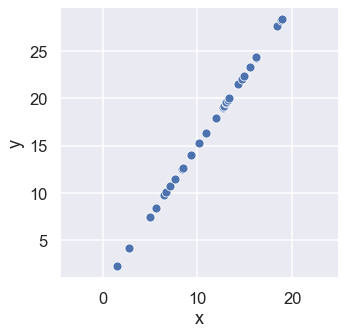

In [50]:
plt.figure(figsize=(5, 5))
sns.scatterplot('x', 'y', data=points)
plt.axis('equal');

In [51]:
u, s, vt = np.linalg.svd(points.values, full_matrices=False)
print(f'u: {u.shape}, vt: {vt.shape}, s: {s}')

u: (30, 2), vt: (2, 2), s: [120.88   0.  ]


In [52]:
points.values @ vt.T

array([[ -2.8 ,  -0.  ],
       [ -5.04,  -0.  ],
       [ -8.97,  -0.  ],
       ...,
       [-33.21,  -0.  ],
       [-34.  ,  -0.  ],
       [-34.08,  -0.  ]])

We can represent the pattern in the data using only one dimension which SVD finds for us. The direction of this dimenion is the first row in the $ V^\top $ matrix!

In [55]:
x_dir, y_dir = -vt[0]
x_dir, y_dir

(0.5547001962252294, 0.8320502943378435)

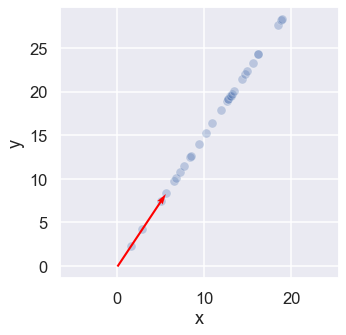

In [56]:
plt.figure(figsize=(5, 5))
sns.scatterplot('x', 'y', data=points, alpha=0.3)
plot_vec(x_dir, y_dir)
plt.axis('equal');

In [60]:
projection = (points.values @ vt.T)[:, 0]
projection

array([ -2.8 ,  -5.04,  -8.97, ..., -33.21, -34.  , -34.08])

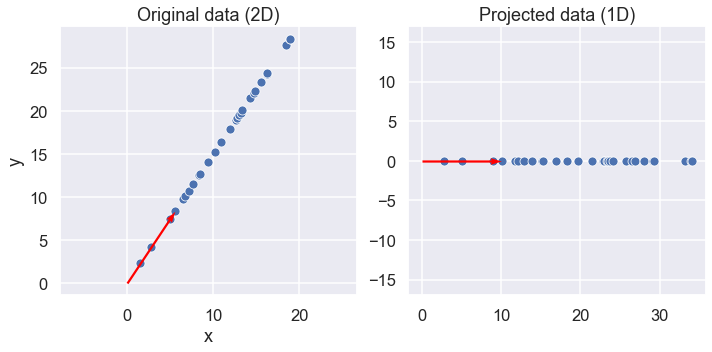

In [61]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
sns.scatterplot('x', 'y', data=points)
plot_vec(x_dir, y_dir)
plt.axis('equal')
plt.title('Original data (2D)')

plt.subplot(122)
sns.scatterplot(-projection, np.zeros(len(u)))
plot_vec(1, 0)
plt.axis('equal')
plt.title('Projected data (1D)')

plt.tight_layout()

So, even if we have 100 columns in the original data, if SVD shows only two singular values then we know we can represent the data using two dimensions.

## Principal Component Analysis (Preview)

In [62]:
D = vote_pivot.values
n = D.shape[0]
X = (D - np.mean(D, axis=0)) / np.sqrt(n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

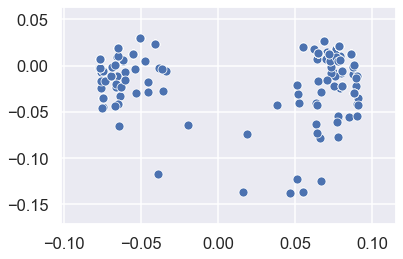

In [63]:
t = X @ vt.T
sns.scatterplot(x=t[:, 0], y=t[:, 1]);

PCA finds the party split without knowing anything about political parties:

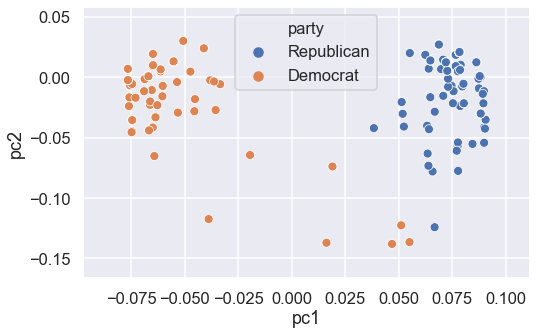

In [64]:
vote2d = pd.DataFrame({
    'member': vote_pivot.index,
    'pc1': t[:, 0],
    'pc2': t[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

plt.figure(figsize=(8, 5))
sns.scatterplot(x='pc1', y='pc2', hue='party', data=vote2d)

## PCA Intuition: Going from 2D to 1D

In [ ]:
# Downloads from https://www.gapminder.org/data/
cm_path = 'child_mortality_0_5_year_olds_dying_per_1000_born.csv'
fe_path = 'children_per_woman_total_fertility.csv'
cm = pd.read_csv(cm_path).set_index('country')['2017'].to_frame()/10
fe = pd.read_csv(fe_path).set_index('country')['2017'].to_frame()
data = cm.merge(fe, left_index=True, right_index=True).dropna()
data.columns = ['mortality', 'fertility']
data.head()

In [ ]:
def scatter():
    sns.scatterplot('mortality', 'fertility', data=data)
    plt.xlim([0, 14])
    plt.ylim([0, 14])
    plt.xticks(np.arange(0, 14, 2))
    plt.yticks(np.arange(0, 14, 2))


scatter()

In [ ]:
x, y = data['mortality'], data['fertility']
slope_x, intercept_x = np.polyfit(x, y, 1) # simple linear regression

scatter()
plt.plot(x, slope_x * x + intercept_x)
for _, row in data.sample(20).iterrows():
    x, y = row['mortality'], row['fertility']
    plt.plot([x, x], [slope_x * x + intercept_x, y], c='red')

In [ ]:
x, y = data['mortality'], data['fertility']
slope_y, intercept_y = np.polyfit(y, x, 1) # simple linear regression

scatter()
plt.plot(x, slope_x * x + intercept_x)
plt.plot(slope_y * y + intercept_y, y)
for _, row in data.sample(20).iterrows():
    x, y = row['mortality'], row['fertility']
    plt.plot([x, slope_y * y + intercept_y], [y, y], c='red')

In [ ]:
from sklearn.decomposition import PCA

plt.figure(figsize=(10, 10))

D = data.values
means = np.mean(D, axis=0)
first_pc = PCA(n_components=1).fit(D).components_[0]

# Find the projection of each point onto the 
#   first principal component (first_pc).
line = np.outer((D - means) @ first_pc, first_pc) + means

x, y = data['mortality'], data['fertility']
scatter()
plt.plot(x, slope_x * x + intercept_x) # regression line for x
plt.plot(slope_y * y + intercept_y, y) # regression line for y
plt.plot(line[:, 0], line[:, 1])       # principal component line

for i, row in data.reset_index().sample(20).iterrows():
    x, y = row['mortality'], row['fertility']
    xp, yp = line[i, :]
    plt.plot([x, xp], [y, yp], c='red')